In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV



In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')  # Télécharger les ressources nécessaires pour l'étiquetage grammatical


[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading averaged_perceptron_tagger: <

False

# I-Collecte de données 



Dans cette étape, nous avons collecter un ensemble de données étiquetées qui contiennent à la fois des exemples de messages spam et des exemples de messages non spam à travers des applications comme : 

     -twilio
     -lemlist
     -waalaxy
     -mailchimp
     -brevo
  
  
Puis on a stocké ces données dans un fichier csv

In [3]:
import csv
import random

fichier_texte = r"C:\Users\awa29\OneDrive\Bureau\Stage NLP\message.txt"
fichier_csv = r"C:\Users\awa29\OneDrive\Bureau\Stage NLP\message.csv"

# Lire le fichier texte
with open(fichier_texte, 'r', encoding='utf-8-sig') as file:
    lines = file.readlines()


with open(fichier_csv, 'w', newline='', encoding='utf-8-sig') as file:
    writer = csv.writer(file)

    # Écrire l'en-tête du fichier CSV
    writer.writerow(["Message", "Type"])

    for line in lines:
        # Vérifier si la ligne contient un point-virgule
        if ';' in line:
            # Séparer le message et le type en utilisant un point-virgule comme séparateur
            message, typ = line.strip().split(';', maxsplit=1)

            # Écrire le message et le type dans le fichier CSV
            writer.writerow([message, typ])

print("Fichier CSV créé avec succès.")


Fichier CSV créé avec succès.


In [4]:
import pandas as pd

csv_file_path = r"C:\Users\awa29\OneDrive\Bureau\Stage NLP\message.csv"

df = pd.read_csv(csv_file_path)

df = df.sample(frac=1).reset_index(drop=True)




In [5]:
df.iloc[0:10, :]



,Message,Type
0,URGENT : Gagnez de l'argent rapidement et faci...,Spam
1,"Ne vous inquiétez pas, je ne partagerai vos ré...",Spam
2,"Cher {{firstname}} : Malheureusement, votre ré...",Non spam
3,"Cher(e) {{civility}} {{lastName}}, ceci est un...",Non spam
4,Obtenez des résultats instantanés avec notre p...,Spam
5,À la recherche de nouvelles opportunités profe...,Non spam
6,Félicitations ! Vous avez gagné un prix incroy...,Spam
7,Poste vacant : {{other}}. Envoyez votre CV à {...,Non spam
8,"En tant qu'abonné(e) privilégié(e), {{firstNam...",Non spam
9,Répondez à ce sondage et gagnez un voyage grat...,Spam


In [6]:
df["Message"]

0     URGENT : Gagnez de l'argent rapidement et faci...
1     Ne vous inquiétez pas, je ne partagerai vos ré...
2     Cher {{firstname}} : Malheureusement, votre ré...
3     Cher(e) {{civility}} {{lastName}}, ceci est un...
4     Obtenez des résultats instantanés avec notre p...
                            ...                        
74    Gagnez de l'argent en ligne avec notre système...
75    Promotion du jour : {{other}} à {{other}}. Fai...
76    Obtenez des milliers de followers et likes sur...
77    Appartement à vendre ! Ne manquez pas cette op...
78    Cher(e) {{civility}} {{lastName}}, veuillez no...
Name: Message, Length: 79, dtype: object

In [7]:
message_value = df.loc[75, "Message"]
print(message_value)


Promotion du jour : {{other}} à {{other}}. Faites vite, cette offre se termine ce soir. Commandez dès maintenant : {{link}}.


# II-Analyse Descriptive

In [8]:
summary_stats = df.describe()
summary_stats


,Message,Type
count,79,79
unique,79,2
top,URGENT : Gagnez de l'argent rapidement et faci...,Non spam
freq,1,43


In [9]:
type_email_counts = df['Type'].value_counts()
total_emails = len(df['Type'])
pourcentages = (type_email_counts / total_emails) * 100

print(pourcentages)


Non spam    54.43038
Spam        45.56962
Name: Type, dtype: float64


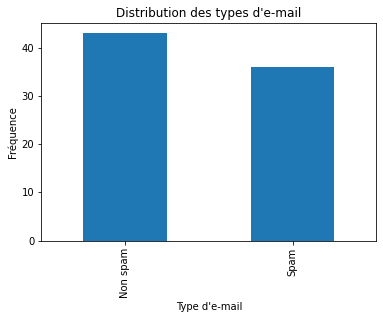

In [10]:
type_email_counts.plot(kind='bar')
plt.xlabel("Type d'e-mail")
plt.ylabel("Fréquence")
plt.title("Distribution des types d'e-mail")
plt.show()



On a une équilibre entre les exemples de spam et de non spam dans notre ensemble de données pour éviter tout biais dans l'apprentissage du modèle.

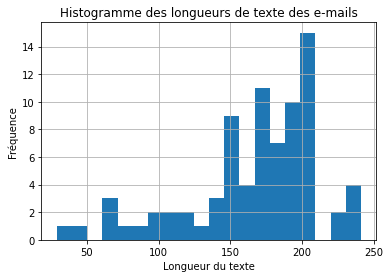

In [11]:
# Calculer les longueurs des textes d'e-mails
df["Longueur du texte"] = df["Message"].apply(lambda x: len(x))

# Créer l'histogramme
df["Longueur du texte"].hist(bins=20)
plt.xlabel("Longueur du texte")
plt.ylabel("Fréquence")
plt.title("Histogramme des longueurs de texte des e-mails")
plt.show()


In [12]:
#!pip install textblob

In [13]:
from textblob import TextBlob



In [14]:
# Créer une nouvelle colonne pour la polarité et la subjectivité
df['Polarité'] = 0.0
df['Subjectivité'] = 0.0

# Appliquer l'analyse de sentiment à chaque texte d'e-mail
for i, row in df.iterrows():
    text = row['Message']
    blob = TextBlob(text)
    polarité = blob.sentiment.polarity
    subjectivité = blob.sentiment.subjectivity
    df.at[i, 'Polarité'] = polarité
    df.at[i, 'Subjectivité'] = subjectivité

print(df[['Message', 'Polarité', 'Subjectivité']])


                                              Message  Polarité  Subjectivité
0   URGENT : Gagnez de l'argent rapidement et faci...    0.0000      0.000000
1   Ne vous inquiétez pas, je ne partagerai vos ré...    0.0000      0.000000
2   Cher {{firstname}} : Malheureusement, votre ré...    0.0000      0.000000
3   Cher(e) {{civility}} {{lastName}}, ceci est un...    0.0000      0.000000
4   Obtenez des résultats instantanés avec notre p...    0.0000      0.000000
..                                                ...       ...           ...
74  Gagnez de l'argent en ligne avec notre système...    0.0000      0.000000
75  Promotion du jour : {{other}} à {{other}}. Fai...   -0.4375      0.687500
76  Obtenez des milliers de followers et likes sur...    0.0000      0.666667
77  Appartement à vendre ! Ne manquez pas cette op...   -0.1250      0.375000
78  Cher(e) {{civility}} {{lastName}}, veuillez no...   -0.4375      0.687500

[79 rows x 3 columns]


 Polarité » : La colonne « Polarité » représente la polarité du sentiment associé à chaque e-mail. La polarité est généralement mesurée sur une échelle continue, allant de -1 à 1. Une valeur proche de -1 indique un sentiment négatif, une valeur proche de 1 indique un sentiment positif, et une valeur proche de 0 indique un sentiment neutre.
« Subjectivité » : La colonne « Subjectivité » représente le degré de subjectivité du contenu de chaque e-mail. La subjectivité est également mesurée sur une échelle continue, allant de 0 à 1. Une valeur proche de 0 indique un contenu objectif, basé sur des faits ou des informations générales, tandis qu’une valeur proche de 1 indique un contenu subjectif, basé sur des opinions ou des émotions personnelles.

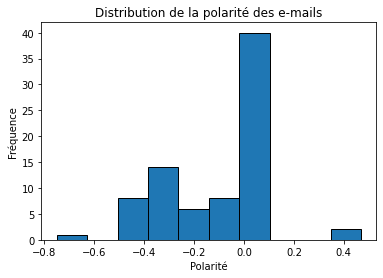

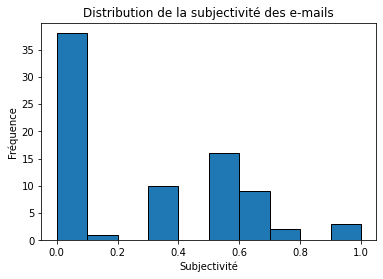

In [15]:
import matplotlib.pyplot as plt

# Créer un histogramme de la polarité des e-mails
plt.hist(df['Polarité'], bins=10, edgecolor='black')
plt.xlabel('Polarité')
plt.ylabel('Fréquence')
plt.title('Distribution de la polarité des e-mails')
plt.show()

# Créer un histogramme de la subjectivité des e-mails
plt.hist(df['Subjectivité'], bins=10, edgecolor='black')
plt.xlabel('Subjectivité')
plt.ylabel('Fréquence')
plt.title('Distribution de la subjectivité des e-mails')
plt.show()


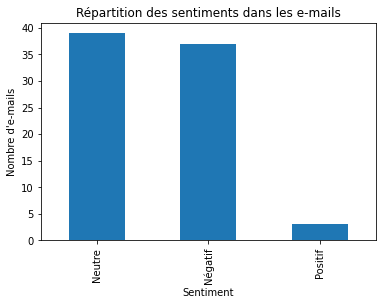

In [16]:
# Compter les occurrences de chaque sentiment
sentiment_counts = df['Polarité'].apply(lambda x: 'Positif' if x > 0 else ('Négatif' if x < 0 else 'Neutre')).value_counts()

# Créer un diagramme en barres du sentiment
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'e-mails')
plt.title('Répartition des sentiments dans les e-mails')
plt.show()


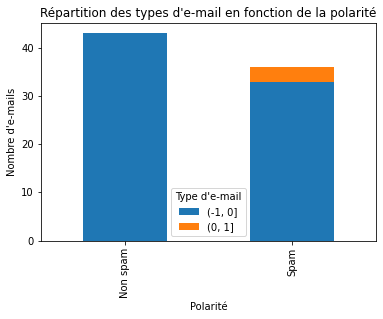

In [17]:
import matplotlib.pyplot as plt

# Créer un diagramme en barres empilées de la répartition des types d'e-mail en fonction de la polarité
stacked_bar = df.groupby(['Type', pd.cut(df['Polarité'], bins=[-1, 0, 1])]).size().unstack().plot(kind='bar', stacked=True)

# Ajouter des étiquettes et des titres
plt.xlabel('Polarité')
plt.ylabel('Nombre d\'e-mails')
plt.title('Répartition des types d\'e-mail en fonction de la polarité')
plt.legend(title='Type d\'e-mail')
plt.show()


 
# Nettoyage du Texte

Pour le nettoyage du texte, nous allons effectuer ces différentes étapes :

     -Nettoyage du texte en supprimant les caractères indésirables tels que la ponctuation, les symboles spéciaux, etc.
   
     -Normalisation du texte en convertissant les caractères en minuscules et en appliquant d'autres transformations pour       uniformiser le texte.
   
      -Suppression des mots vides (stop words) tels que "et", "mais", "ou", qui n'apportent pas beaucoup d'informations pour la   classification.
   
     -Tokenisation du texte en divisant les phrases en mots ou en tokens individuels.
     
      - Supprimer les variables personnalisées

Dans un premier temps, nous allons étiqueter notre variable cible appelée "Type".

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['encoded'] = encoder.fit_transform(df['Type'])
df.head()

,Message,Type,Longueur du texte,Polarité,Subjectivité,encoded
0,URGENT : Gagnez de l'argent rapidement et faci...,Spam,165,0.0,0.0,1
1,"Ne vous inquiétez pas, je ne partagerai vos ré...",Spam,66,0.0,0.0,1
2,"Cher {{firstname}} : Malheureusement, votre ré...",Non spam,241,0.0,0.0,0
3,"Cher(e) {{civility}} {{lastName}}, ceci est un...",Non spam,190,0.0,0.0,0
4,Obtenez des résultats instantanés avec notre p...,Spam,196,0.0,0.0,1


In [19]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french')) #les mots à enlever
print(stop_words)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [20]:
import re
import unicodedata
from urllib.parse import urlparse
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

def clean_text(text):
    # Convertir en minuscules
    text = text.lower()

    # Retirer les accents
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    # Retirer la ponctuation
    text = re.sub('[%s]' % re.escape(punctuation), '', text)

    # Remplacer les crochets par un espace
    text = re.sub('[][)(]', ' ', text)

    # Supprimer les URL
    text = [word for word in text.split() if not urlparse(word).scheme]
    text = ' '.join(text)

    # Supprimer les mots commençant par @
    text = re.sub(r'\@\w+', '', text)

    # Supprimer les balises HTML
    text = re.sub(re.compile("<.*?>"), '', text)

    # Obtenir uniquement les caractères et les chiffres
    text = re.sub('[^A-Za-z0-9]', ' ', text)

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

     # Retirer les stop words, y compris les mots spécifiques
    stop_words = set(stopwords.words('french'))
    stop_words.update(['phone', 'lastname', 'firstname', 'civility', 'date', 'time', 'sender', 'link', 'other'])
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text




In [21]:
# Appliquer la fonction de nettoyage sur la colonne 'Message'

df['Cleaned_Content'] = df['Message'].apply(clean_text)



In [22]:
df.iloc[1:10,]

,Message,Type,Longueur du texte,Polarité,Subjectivité,encoded,Cleaned_Content
1,"Ne vous inquiétez pas, je ne partagerai vos ré...",Spam,66,0.000000,0.000000,1,inquietez pa partagerai reponses personne
2,"Cher {{firstname}} : Malheureusement, votre ré...",Non spam,241,0.000000,0.000000,0,cher malheureusement reservation attente na pa...
3,"Cher(e) {{civility}} {{lastName}}, ceci est un...",Non spam,190,0.000000,0.000000,0,chere ceci rappel amical concernant paiement f...
4,Obtenez des résultats instantanés avec notre p...,Spam,196,0.000000,0.000000,1,obtenez resultats instantanes programme remise...
5,À la recherche de nouvelles opportunités profe...,Non spam,229,-0.333333,0.583333,0,a recherche nouvelles opportunites professionn...
6,Félicitations ! Vous avez gagné un prix incroy...,Spam,106,0.000000,0.000000,1,felicitation gagne prix incroyable cliquez lie...
7,Poste vacant : {{other}}. Envoyez votre CV à {...,Non spam,117,-0.437500,0.687500,0,poste vacant envoyez cv a postuler avant plus ...
8,"En tant qu'abonné(e) privilégié(e), {{firstNam...",Non spam,175,-0.281250,0.531250,0,tant quabonnee privilegiee beneficiez dune red...
9,Répondez à ce sondage et gagnez un voyage grat...,Spam,89,0.468750,1.000000,1,repondez a sondage gagnez voyage gratuit manqu...


In [23]:
df['Cleaned_Content']

0     urgent gagnez largent rapidement facilement cl...
1             inquietez pa partagerai reponses personne
2     cher malheureusement reservation attente na pa...
3     chere ceci rappel amical concernant paiement f...
4     obtenez resultats instantanes programme remise...
                            ...                        
74    gagnez largent ligne systeme generation revenu...
75    promotion jour a faites vite cette offre termi...
76    obtenez milliers follower like reseau sociaux ...
77    appartement a vendre manquez pa cette opportun...
78    chere veuillez noter no nouveaux horaires douv...
Name: Cleaned_Content, Length: 79, dtype: object

# Extraction de fonctionnalités 



Dans cette étape, vous allons identifier les caractéristiques pertinentes dans les messages qui peuvent aider à distinguer les spams des messages normaux. Certaines fonctionnalités couramment utilisées incluent :

La fréquence des mots : combien de fois chaque mot apparaît dans un message.
La présence de mots clés : vérifier si certains mots clés associés aux spams sont présents dans un message.
La présence de liens ou d'adresses e-mail : détecter si un message contient des liens ou des adresses e-mail souvent utilisés dans les spams.
La longueur du message : les spams ont souvent tendance à être plus courts ou plus longs que les messages normaux.

Et pour cela on va utuliser effectue la vectorisation TF-IDF des données textuelles de la colonne 'Cleaned_Content' du DataFrame df et crée un nouveau DataFrame X contenant les valeurs TF-IDF correspondantes. Cette représentation vectorielle peut être utilisée comme entrée pour l'apprentissage automatique ou d'autres tâches d'analyse de texte.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Définir la valeur de min_df
MIN_DF = 1

# Créer une instance de TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=MIN_DF)

# Appliquer la vectorisation TF-IDF sur la colonne 'Cleaned_Content'
X_vec = vectorizer.fit_transform(df["Cleaned_Content"])

# Convertir la matrice creuse en un tableau numpy
X_array = X_vec.toarray()

# Créer un DataFrame avec les valeurs TF-IDF
X = pd.DataFrame(X_array, columns=vectorizer.get_feature_names_out())
X.head()


,abonnes,abouti,achat,achetant,achetez,acquerez,acteurs,adieu,adresse,algorithme,...,virtuelle,visibilite,visitant,visons,vite,voir,voyage,web,webinar,youtube
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.205796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Construction du modèle

Dans cette partie on va tester plusieurs modeles de classification

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [26]:
y = df["encoded"]

In [27]:
X

,abonnes,abouti,achat,achetant,achetez,acquerez,acteurs,adieu,adresse,algorithme,...,virtuelle,visibilite,visitant,visons,vite,voir,voyage,web,webinar,youtube
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.205796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
75,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362333,0.0,0.0,0.000000,0.0,0.0
76,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
77,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [28]:
y

0     1
1     1
2     0
3     0
4     1
     ..
74    1
75    0
76    1
77    0
78    0
Name: encoded, Length: 79, dtype: int32

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


In [30]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
accuracy = model_log.score(X_test, y_test)
print("Précision du modèle Regression logistic :", accuracy)

Précision du modèle Regression logistic : 0.6666666666666666


In [31]:
model_nb_ber = MultinomialNB()
model_nb_ber.fit(X_train, y_train)
accuracy = model_nb_ber.score(X_test, y_test)
print("Précision du modèle Naive Bayes Bernoulli :", accuracy)


Précision du modèle Naive Bayes Bernoulli : 0.7916666666666666


In [32]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
accuracy_rf = model_rf.score(X_test, y_test)
print("Précision du modèle de random Forest :", accuracy_rf)


Précision du modèle de random Forest : 0.6666666666666666


In [33]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
accuracy_svm = model_svm.score(X_test, y_test)
print("Précision du modèle SVM :", accuracy_svm)



Précision du modèle SVM : 0.625


In [34]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
accuracy_knn = model_knn.score(X_test, y_test)
print("Précision du modèle KNN :", accuracy_knn)

Précision du modèle KNN : 0.875


## Avec les Hyperparamètres 

In [35]:
from sklearn.model_selection import GridSearchCV



In [36]:
params_nb = {'alpha': [0.1, 0.5, 1.0]}
params_logistic = {'C': [0.1, 1.0, 10.0]}
params_knn = {'n_neighbors': [3, 5, 7]}
params_svm = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']}
params_random = {'n_estimators': [100, 200, 300]}


In [37]:
grid_nb = GridSearchCV(MultinomialNB(), params_nb, cv=5)
grid_logistic = GridSearchCV(LogisticRegression(), params_logistic, cv=5)
grid_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=5)
grid_svm = GridSearchCV(SVC(), params_svm, cv=5)
grid_random = GridSearchCV(RandomForestClassifier(), params_random, cv=5)



In [38]:
grid_nb.fit(X_train, y_train)
grid_logistic.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_random.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 200, 300]})

In [39]:
best_params_nb = grid_nb.best_params_
best_accuracy_nb = grid_nb.best_score_
print("Meilleurs hyperparamètres pour Naive Bayes :", best_params_nb)
print("Précision du meilleur modèle Naive Bayes :", best_accuracy_nb)

best_params_logistic = grid_logistic.best_params_
best_accuracy_logistic = grid_logistic.best_score_
print("Meilleurs hyperparamètres pour Régression Logistique :", best_params_logistic)
print("Précision du meilleur modèle Régression Logistique :", best_accuracy_logistic)


Meilleurs hyperparamètres pour Naive Bayes : {'alpha': 0.5}
Précision du meilleur modèle Naive Bayes : 0.7636363636363637
Meilleurs hyperparamètres pour Régression Logistique : {'C': 10.0}
Précision du meilleur modèle Régression Logistique : 0.7818181818181819


In [40]:
best_params_knn = grid_knn.best_params_
best_accuracy_knn = grid_knn.best_score_
print("Meilleurs hyperparamètres pour KNN :", best_params_knn)
print("Précision du meilleur modèle KNN :", best_accuracy_knn)

best_params_svm = grid_svm.best_params_
best_accuracy_svm = grid_svm.best_score_
print("Meilleurs hyperparamètres pour SVM :", best_params_svm)
print("Précision du meilleur modèle SVM :", best_accuracy_svm)

best_params_random = grid_random.best_params_
best_accuracy_random = grid_random.best_score_
print("Meilleurs hyperparamètres pour Random Forest :", best_params_random)
print("Précision du meilleur modèle Random Forest :", best_accuracy_random)


Meilleurs hyperparamètres pour KNN : {'n_neighbors': 5}
Précision du meilleur modèle KNN : 0.7636363636363637
Meilleurs hyperparamètres pour SVM : {'C': 1.0, 'kernel': 'linear'}
Précision du meilleur modèle SVM : 0.7818181818181819
Meilleurs hyperparamètres pour Random Forest : {'n_estimators': 100}
Précision du meilleur modèle Random Forest : 0.7454545454545454


Notre meilleur modele est le **Naive bayes** d'apres les résultats

In [41]:
from joblib import dump


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


modele_final= MultinomialNB()
modele_final.fit(X_train, y_train)

# Sauvegarder le modèle dans un fichier
dump(modele_final, r"C:\Users\awa29\OneDrive\Bureau\Stage NLP\modele.joblib")


['C:\\Users\\awa29\\OneDrive\\Bureau\\Stage NLP\\modele.joblib']

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       1.00      0.55      0.71        11

    accuracy                           0.79        24
   macro avg       0.86      0.77      0.77        24
weighted avg       0.85      0.79      0.78        24



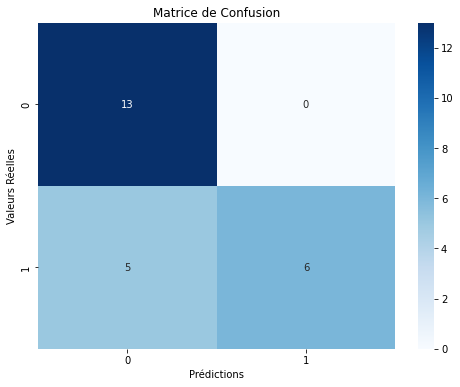

In [43]:
y_pred =modele_final.predict(X_test)

print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()


# Fonction Test

In [44]:
!pip install pika


In [45]:
from joblib import load
import pika


In [46]:
import unicodedata
import re
from string import punctuation
from urllib.parse import urlparse
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Définir la valeur de min_df
MIN_DF = 1

def clean_text(text):
    # Convertir en minuscules
    text = text.lower()

    # Retirer les accents
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    # Retirer la ponctuation
    text = re.sub('[%s]' % re.escape(punctuation), '', text)

    # Remplacer les crochets par un espace
    text = re.sub('[][)(]', ' ', text)

    # Supprimer les URL
    text = [word for word in text.split() if not urlparse(word).scheme]
    text = ' '.join(text)

    # Supprimer les mots commençant par @
    text = re.sub(r'\@\w+', '', text)

    # Supprimer les balises HTML
    text = re.sub(re.compile("<.*?>"), '', text)

    # Obtenir uniquement les caractères et les chiffres
    text = re.sub('[^A-Za-z0-9]', ' ', text)

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

     # Retirer les stop words, y compris les mots spécifiques
    stop_words = set(stopwords.words('french'))
    stop_words.update(['phone', 'lastname', 'firstname', 'civility', 'date', 'time', 'sender', 'link', 'other'])
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

def test(text):
    cleaned_text = clean_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])
    result = modele_final.predict(vectorized_text)
    return result



In [47]:
text= "Salut {{firstname}}, Je suppose que vous êtes trop occupé pour regarder cela en ce moment? "
message_spam = "Obtenez maintenant des produits de santé gratuits ! Réclamez votre récompense en cliquant sur le lien ci-dessous : http://example.com"
sms="Enrichissez-vous grâce à notre système de trading automatique, {{civility}} {{firstName}} {{lastName}}. Pas besoin d'expérience préalable, laissez notre logiciel générer des revenus passifs pour vous."

In [56]:
print(test(text))


[0]


In [55]:
r=test(sms)
r

array([1])

Array[0] qui signifie que le text est considéré  **Non Spam**

Array[1] qui signifie que le text est considéré  **Spam**


In [50]:
# Charger votre modèle Naive Bayes
modele_final = load(r"C:\Users\awa29\OneDrive\Bureau\Stage NLP\modele.joblib")
modele_final

MultinomialNB()

In [57]:
def process_message(channel, method, properties, body):
    message = body.decode('utf-8')

    # Récupérer le statut du message depuis les propriétés
    status = properties.headers.get('statut')

    # Récupérer l'IDE depuis les propriétés
    ide = properties.headers.get('IDE')

    # Nettoyer le texte
    cleaned_text = clean_text(message)

    # Effectuer la prédiction avec le modèle
    result = test(cleaned_text)

    # Prendre des mesures en fonction du résultat
    if result==1:
        # Message identifié comme un spam
        print("Message identifié comme un spam :", message)
        
    else:
        # Message non-spam
        print("Message non-spam :", message)

    # Indiquer à RabbitMQ que le message a été traité
    channel.basic_ack(delivery_tag=method.delivery_tag)

# Établir la connexion avec RabbitMQ
connection = pika.BlockingConnection(pika.ConnectionParameters('localhost'))
channel = connection.channel()

# Déclarer la file d'attente à consommer
channel.queue_declare(queue='tech.message.queuesanalyses', durable=True)

# Définir la fonction de rappel pour le traitement des messages
channel.basic_consume(queue='tech.message.queuesanalyses', on_message_callback=process_message)

# Démarrer la consommation des messages
channel.start_consuming()


KeyboardInterrupt: 